In [18]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [19]:
## hyper parameters:
BATCH_SIZE = 64
EPOCH = 50
LR = 0.001
VAL_SPLIT = 0.2

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using GPU' if device else 'using CPU')

using GPU


In [27]:
## dataset
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_set = datasets.FashionMNIST('/data/mnist', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('/data/mnist', download=True, train=False, transform=transform)

# inja validation va train data ro joda mikonim:
indices = list(range(len(train_set)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(train_set)))
train_sample = SubsetRandomSampler(indices[:split])
val_sample = SubsetRandomSampler(indices[split:])
# hala data loader:
train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sample, batch_size = 64)
val_loader = torch.utils.data.DataLoader(train_set, sampler=val_sample, batch_size = 64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

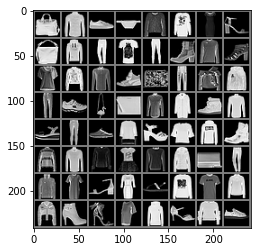

In [28]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

train_dataset = iter(train_loader)
images, labels = train_dataset.next()
imshow(torchvision.utils.make_grid(images))

In [29]:
def build_fine_tune_model():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    model = model.to(device)
    return model

def build_backbone_model():
    model = torchvision.models.resnet18(pretrained=True)
    #inja parameter haro freeze mikonim:
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    model = model.to(device)
    return model

In [30]:
class myNeuralNetwork(nn.Module):
    
    def __init__(self):
        super(myNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(kernel_size=5, padding=2, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        pass

In [31]:
def train_model(model, criterion, optimizer, scheduler, val_acc,
               val_loss, train_acc, train_loss, num_epoch):
    
    # train phase:
    model.train()
    for epoch in range(num_epoch):
        scheduler.step()
        accuracy = 0
        abs_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            abs_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            accuracy += torch.sum(preds == labels.data)
        
        train_acc.append(accuracy/len(train_loader))
        train_loss.append(abs_loss/len(train_loader))
               
    # validation phase:
    model.eval()
    for epoch in range(num_epoch):
        accuracy = 0
        abs_loss = 0
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            abs_loss += loss.item()
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            _, preds = torch.max(outputs, 1)
            accuracy += torch.sum(preds == labels.data)
        
        val_acc.append(accuracy/len(val_loader))
        val_loss.append(abs_loss/len(val_loader))
        
    return model, train_acc, train_loss, val_acc, val_loss

In [ ]:
model = build_backbone_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

val_acc = []
val_loss = []
train_acc = []
train_loss = []

model = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, train_acc, train_loss, 5)